In [51]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

***Carrying out all the imports that will be needed.***

In [52]:
import os
import pandas as pd
import glob
import cv2
import PIL
import matplotlib.pyplot as plt
import xml.etree.cElementTree as ET
import ast
from tqdm import tqdm


import argparse
import multiprocessing
import os
import sys

import cv2
import numpy
import tensorflow as tf



import os
import numpy
import tensorflow as tf
#import tensorflow_addons as tfa

from tensorflow.keras import utils
import xml

#os.chdir('../')

***Testing for GPU***

In [53]:
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))

GPU device not found
Found GPU at: 


***Helper functions***

In [54]:
from  copy import copy

def get_bbox(annots):
    bboxes = [list(annot.values()) for annot in annots]
    return bboxes
def get_path(row):
    row['image_path'] = f'{TRAIN_PATH}/train_images/video_{row.video_id}/{row.video_frame}.jpg'
    return row
#f'./working/data_dir/COTS_UNANNOTATED/images/{row.image_id}.jpg')

def get_path_preprocessed(row):
    row['image_path_preprocessed'] = f'{TRAIN_PATH_PREPROCESSED}/images_preprocessed/video_{row.video_id}_{row.video_frame}.jpg'
    return row
def get_unannotated_path(row):
    row['image_path_unannotated'] = f'{UNANNOTATED_PATH}/images_preprocessed/{row.image_id}.jpg'
    return row

def load_image(image_path):
    return cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)



def yolo2voc(bboxes, image_height=720, image_width=1280):
    """
    yolo => [xmid, ymid, w, h] (normalized)
    voc  => [x1, y1, x2, y1]
    
    """ 
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    
    bboxes[..., [0, 2]] = bboxes[..., [0, 2]]* image_width
    bboxes[..., [1, 3]] = bboxes[..., [1, 3]]* image_height
    
    bboxes[..., [0, 1]] = bboxes[..., [0, 1]] - bboxes[..., [2, 3]]/2
    bboxes[..., [2, 3]] = bboxes[..., [0, 1]] + bboxes[..., [2, 3]]
    
    return bboxes

def coco2yolo(image_height, image_width, bboxes):
    """
    coco => [xmin, ymin, w, h]
    yolo => [xmid, ymid, w, h] (normalized)
    """
    
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    
    # normolizinig
    bboxes[..., [0, 2]]= bboxes[..., [0, 2]]/ image_width
    bboxes[..., [1, 3]]= bboxes[..., [1, 3]]/ image_height
    
    # converstion (xmin, ymin) => (xmid, ymid)
    bboxes[..., [0, 1]] = bboxes[..., [0, 1]] + bboxes[..., [2, 3]]/2
    
    return bboxes

def voc2yolo(bboxes, image_height=720, image_width=1280):
    """
    voc  => [x1, y1, x2, y1]
    yolo => [xmid, ymid, w, h] (normalized)
    """
    
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    
    bboxes[..., [0, 2]] = bboxes[..., [0, 2]]/ image_width
    bboxes[..., [1, 3]] = bboxes[..., [1, 3]]/ image_height
    
    w = bboxes[..., 2] - bboxes[..., 0]
    h = bboxes[..., 3] - bboxes[..., 1]
    
    bboxes[..., 0] = bboxes[..., 0] + w/2
    bboxes[..., 1] = bboxes[..., 1] + h/2
    bboxes[..., 2] = w
    bboxes[..., 3] = h
    
    return bboxes

def yolo2coco(image_height, image_width, bboxes):
    """
    yolo => [xmid, ymid, w, h] (normalized)
    coco => [xmin, ymin, w, h]
    
    """ 
    #print(bboxes)
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    
    # denormalizing
    bboxes[..., [0, 2]]= bboxes[..., [0, 2]]* image_width
    bboxes[..., [1, 3]]= bboxes[..., [1, 3]]* image_height
    
    # converstion (xmid, ymid) => (xmin, ymin) 
    bboxes[..., [0, 1]] = bboxes[..., [0, 1]] - bboxes[..., [2, 3]]/2
    
    return bboxes

def voc2coco(bboxes, image_height=720, image_width=1280):
    bboxes  = voc2yolo(bboxes, image_height, image_width)
    #print('VOC2COCO', bboxes)
    bboxes  = yolo2coco( image_height, image_width, bboxes)
    return bboxes


def plot_one_box(x, img, color=None, label=None, line_thickness=None):
    # Plots one bounding box on image img
    tl = line_thickness or round(0.002 * (img.shape[0] + img.shape[1]) / 2) + 1  # line/font thickness
    color = color or [random.randint(0, 255) for _ in range(3)]
    c1, c2 = (int(x[0]), int(x[1])), (int(x[2]), int(x[3]))
    cv2.rectangle(img, c1, c2, color, thickness=tl, lineType=cv2.LINE_AA)
    if label:
        tf = max(tl - 1, 1)  # font thickness
        t_size = cv2.getTextSize(label, 0, fontScale=tl / 3, thickness=tf)[0]
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(img, c1, c2, color, -1, cv2.LINE_AA)  # filled
        cv2.putText(img, label, (c1[0], c1[1] - 2), 0, tl / 3, [0, 0, 255], thickness=tf, lineType=cv2.LINE_AA)



def draw_bboxes(img, bboxes, classes, class_ids, colors = None, show_classes = None, bbox_format = 'yolo', class_name = False, line_thickness = 2):  
    image = img.copy()
    show_classes = classes if show_classes is None else show_classes
    colors = (0, 255 ,0) if colors is None else colors
    
    if bbox_format == 'yolo':
        
        for idx in range(len(bboxes)):  
            
            bbox  = bboxes[idx]
            cls   = classes[idx]
            cls_id = class_ids[idx]
            color = colors[cls_id] if type(colors) is list else colors
            
            if cls in show_classes:
            
                x1 = round(float(bbox[0])*image.shape[1])
                y1 = round(float(bbox[1])*image.shape[0])
                w  = round(float(bbox[2])*image.shape[1]/2) #w/2 
                h  = round(float(bbox[3])*image.shape[0]/2)

                voc_bbox = (x1-w, y1-h, x1+w, y1+h)
                plot_one_box(voc_bbox, 
                             image,
                             color = color,
                             label = cls if class_name else str(get_label(cls)),
                             line_thickness = line_thickness)
            
    elif bbox_format == 'coco':
        
        for idx in range(len(bboxes)):  
            
            bbox  = bboxes[idx]
            cls   = classes[idx]
            cls_id = class_ids[idx]
            color = colors[cls_id] if type(colors) is list else colors
            
            if cls in show_classes:            
                x1 = int(round(bbox[0]))
                y1 = int(round(bbox[1]))
                w  = int(round(bbox[2]))
                h  = int(round(bbox[3]))

                voc_bbox = (x1, y1, x1+w, y1+h)
                plot_one_box(voc_bbox, 
                             image,
                             color = color,
                             label = cls if class_name else str(cls_id),
                             line_thickness = line_thickness)

    elif bbox_format == 'voc_pascal':
        
        for idx in range(len(bboxes)):  
            
            bbox  = bboxes[idx]
            cls   = classes[idx]
            cls_id = class_ids[idx]
            color = colors[cls_id] if type(colors) is list else colors
            
            if cls in show_classes: 
                x1 = int(round(bbox[0]))
                y1 = int(round(bbox[1]))
                x2 = int(round(bbox[2]))
                y2 = int(round(bbox[3]))
                voc_bbox = (x1, y1, x2, y2)
                plot_one_box(voc_bbox, 
                             image,
                             color = color,
                             label = cls if class_name else str(cls_id),
                             line_thickness = line_thickness)
    else:
        raise ValueError('wrong bbox format')

    return image

def create_annot(bboxes, bbox_format = 'yolo'):
    annotation=''
    if bbox_format == 'yolo':
        for index,bbox in enumerate(bboxes):
            annot= ('0 '+ ' '.join([str(el) for el in bbox])).strip() +'\n'
            annotation= annotation+annot
            #print(annot)
            #break
    return annotation




#      class x_center y_center width height  

np.random.seed(8)
colors = (np.random.randint(0, 255), np.random.randint(0, 255), np.random.randint(0, 255))
colors=(255,0,0)

***FILES PREPROCESSING AND LOADING***

In [55]:
train_csv_path= './input/tensorflow-great-barrier-reef/train.csv'
test_csv_path= './input/tensorflow-great-barrier-reef/test.csv'

In [56]:
train_csv= pd.read_csv(train_csv_path)
test_csv= pd.read_csv(test_csv_path)

In [57]:
train_csv.head()

video_id  sequence  video_frame  sequence_frame image_id annotations
0         0     40258            0               0      0-0          []
1         0     40258            1               1      0-1          []
2         0     40258            2               2      0-2          []
3         0     40258            3               3      0-3          []
4         0     40258            4               4      0-4          []

In [58]:
test_csv.head()

video_id  sequence  video_frame  sequence_frame image_id
0         3     17063            0               0      3-0
1         3     17063            1               1      3-1
2         3     17063            2               2      3-2

In [59]:
images= glob.glob("./input/tensorflow-great-barrier-reef/train_images/*/*.jpg")

In [60]:
train_csv["NumOfBBox"]=train_csv['annotations'].apply(lambda x: str.count(x, 'x'))
train_csv.head(5)

video_id  sequence  video_frame  sequence_frame image_id annotations  \
0         0     40258            0               0      0-0          []   
1         0     40258            1               1      0-1          []   
2         0     40258            2               2      0-2          []   
3         0     40258            3               3      0-3          []   
4         0     40258            4               4      0-4          []   

   NumOfBBox  
0          0  
1          0  
2          0  
3          0  
4          0

In [61]:
#Thus we see a lot of images with no bboxes.
#We will try to have 1% of such background images in dataset as recommended by ultralytics
print(train_csv["NumOfBBox"].value_counts())

0     18582
1      2801
2       942
3       374
4       240
5       134
7        61
6        59
8        58
11       44
15       40
9        32
16       28
10       26
14       22
13       19
17       19
12       17
18        3
Name: NumOfBBox, dtype: int64


In [62]:
df_train_csv=train_csv#[train_csv["NumOfBBox"]>0]
df_train_csv.sample(2)

video_id  sequence  video_frame  sequence_frame image_id annotations  \
13937         1     60754        10372            1956  1-10372          []   
3388          0     45015         5852             150   0-5852          []   

       NumOfBBox  
13937          0  
3388           0

In [63]:
BATCH_SIZE = 16
EPOCHS = 30
IMG_SIZE=1280
Selected_Fold=2 #0..4

In [64]:
print(df_train_csv['NumOfBBox'].sum())

11898


In [65]:
df_train_csv['annotations'] = df_train_csv['annotations'].apply(lambda x: ast.literal_eval(str(x))) #(lambda x: ast.literal_eval(x))
df_train_csv['bboxes'] = df_train_csv.annotations.apply(get_bbox)

In [66]:
df_train_csv["Width"]=1280
df_train_csv["Height"]=720

In [67]:
TRAIN_PATH= './input/tensorflow-great-barrier-reef/'
TRAIN_PATH_PREPROCESSED= './working/data_dir/yolo/'

In [68]:
df_train_csv = df_train_csv.apply(get_path, axis=1)
df_train_csv.sample(2)

video_id  sequence  video_frame  sequence_frame image_id  ... NumOfBBox  \
9172         1      8503         4020             192   1-4020  ...         0   
6392         0       996        12032             607  0-12032  ...         0   

      bboxes Width  Height                                         image_path  
9172      []  1280     720  ./input/tensorflow-great-barrier-reef//train_i...  
6392      []  1280     720  ./input/tensorflow-great-barrier-reef//train_i...  

[2 rows x 11 columns]

***Do the same for preprocessed paths***

In [69]:
df_train_csv = df_train_csv.apply(get_path_preprocessed, axis=1)
df_train_csv.sample(2)

video_id  sequence  video_frame  sequence_frame image_id  ... bboxes  \
20599         2     29859         7858              86   2-7858  ...     []   
4534          0     35305         8333             679   0-8333  ...     []   

       Width Height                                         image_path  \
20599   1280    720  ./input/tensorflow-great-barrier-reef//train_i...   
4534    1280    720  ./input/tensorflow-great-barrier-reef//train_i...   

                                 image_path_preprocessed  
20599  ./working/data_dir/yolo//images_preprocessed/v...  
4534   ./working/data_dir/yolo//images_preprocessed/v...  

[2 rows x 12 columns]

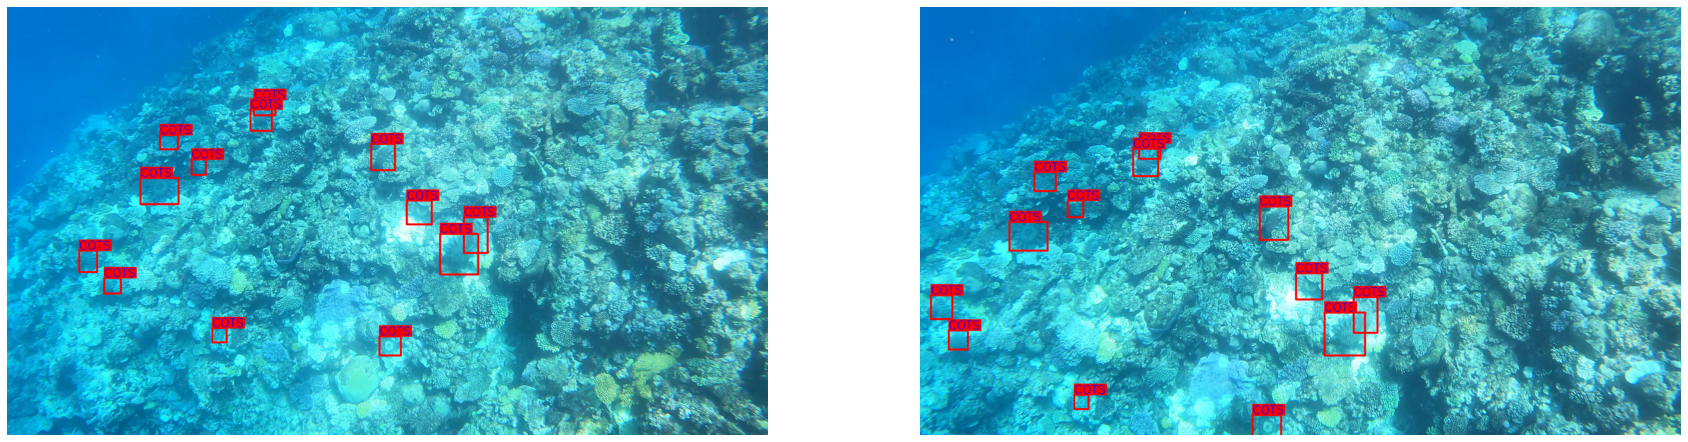

In [70]:
df_v = df_train_csv[(df_train_csv.NumOfBBox==13)].sample(2) 
fig,ax = plt.subplots(1,2,figsize=(30,20))
i=0;
for index, row in df_v.iterrows():
    img           = load_image(row.image_path)
    image_height  = row.Height
    image_width   = row.Width
    bboxes_coco   = np.array(row.bboxes)
    bboxes_yolo   = coco2yolo(image_height, image_width, bboxes_coco)
    names         = ['COTS']*len(bboxes_coco)
    labels        = [0]*len(bboxes_coco)
    im=draw_bboxes(img = img,
                           bboxes = bboxes_yolo, 
                           classes = names,
                           class_ids = labels,
                           class_name = True, 
                           colors = colors, 
                           bbox_format = 'yolo',
                           line_thickness = 2)
    ax[i].imshow(im)
    ax[i].axis('OFF')
    i=i+1

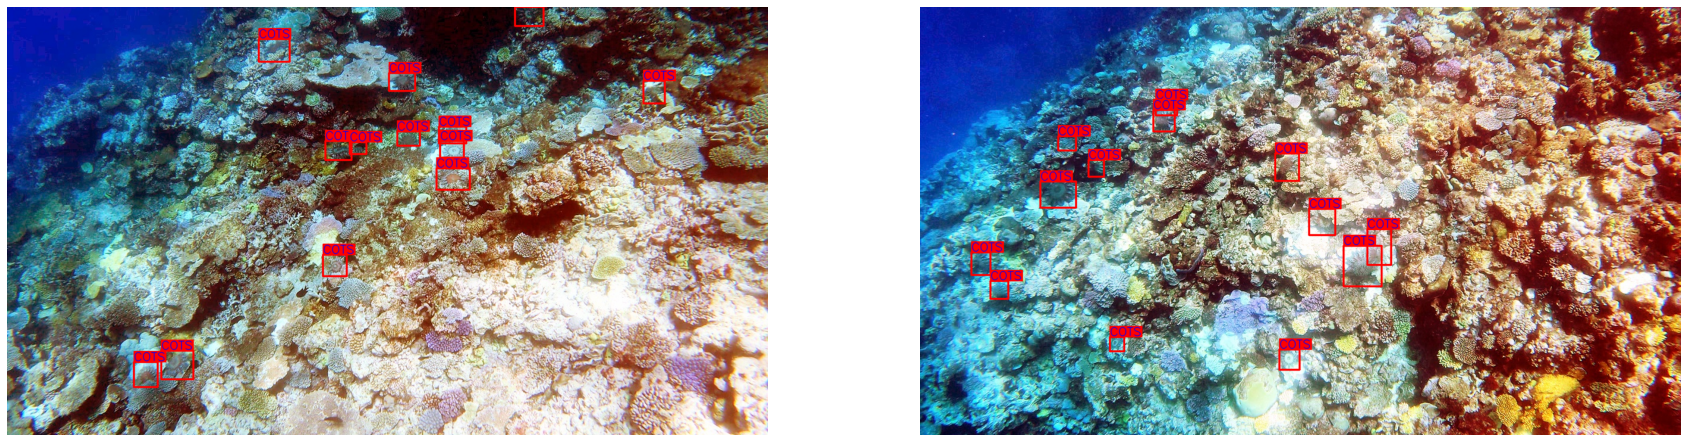

In [71]:
df_v = df_train_csv[(df_train_csv.NumOfBBox==13)].sample(2) 
fig,ax = plt.subplots(1,2,figsize=(30,20))
i=0;
for index, row in df_v.iterrows():
    img           = load_image(row.image_path_preprocessed)
    image_height  = row.Height
    image_width   = row.Width
    bboxes_coco   = np.array(row.bboxes)
    bboxes_yolo   = coco2yolo(image_height, image_width, bboxes_coco)
    names         = ['COTS']*len(bboxes_coco)
    labels        = [0]*len(bboxes_coco)
    im=draw_bboxes(img = img,
                           bboxes = bboxes_yolo, 
                           classes = names,
                           class_ids = labels,
                           class_name = True, 
                           colors = colors, 
                           bbox_format = 'yolo',
                           line_thickness = 2)
    ax[i].imshow(im)
    ax[i].axis('OFF')
    i=i+1

In [72]:
#!pip install scikit-learn

In [73]:
df_train_csv.head()

video_id  sequence  video_frame  sequence_frame image_id  ... bboxes  \
0         0     40258            0               0      0-0  ...     []   
1         0     40258            1               1      0-1  ...     []   
2         0     40258            2               2      0-2  ...     []   
3         0     40258            3               3      0-3  ...     []   
4         0     40258            4               4      0-4  ...     []   

   Width Height                                         image_path  \
0   1280    720  ./input/tensorflow-great-barrier-reef//train_i...   
1   1280    720  ./input/tensorflow-great-barrier-reef//train_i...   
2   1280    720  ./input/tensorflow-great-barrier-reef//train_i...   
3   1280    720  ./input/tensorflow-great-barrier-reef//train_i...   
4   1280    720  ./input/tensorflow-great-barrier-reef//train_i...   

                             image_path_preprocessed  
0  ./working/data_dir/yolo//images_preprocessed/v...  
1  ./working/data_dir/yolo//images_preprocessed/v...  
2  ./working/data_dir/yolo//images_preprocessed/v...  
3  ./working/data_dir/yolo//images_preprocessed/v...  
4  ./working/data_dir/yolo//images_preprocessed/v...  

[5 rows x 12 columns]

In [74]:
train_5_folds_csv= pd.read_csv('./input/sequence_splits/cross-validation/train-5folds.csv')

In [75]:
train_5_folds_csv.head()

video_id  sequence  video_frame  sequence_frame image_id  ...  \
0         0     40258            0               0      0-0  ...   
1         0     40258            1               1      0-1  ...   
2         0     40258            2               2      0-2  ...   
3         0     40258            3               3      0-3  ...   
4         0     40258            4               4      0-4  ...   

  n_annotations  has_annotations  \
0             0            False   
1             0            False   
2             0            False   
3             0            False   
4             0            False   

                                          image_path subsequence_id  fold  
0  ../input/tensorflow-great-barrier-reef/train_i...              1     2  
1  ../input/tensorflow-great-barrier-reef/train_i...              1     2  
2  ../input/tensorflow-great-barrier-reef/train_i...              1     2  
3  ../input/tensorflow-great-barrier-reef/train_i...              1     2  
4  ../input/tensorflow-great-barrier-reef/train_i...              1     2  

[5 rows x 11 columns]

In [76]:
train_5_folds_csv.head(5)

video_id  sequence  video_frame  sequence_frame image_id  ...  \
0         0     40258            0               0      0-0  ...   
1         0     40258            1               1      0-1  ...   
2         0     40258            2               2      0-2  ...   
3         0     40258            3               3      0-3  ...   
4         0     40258            4               4      0-4  ...   

  n_annotations  has_annotations  \
0             0            False   
1             0            False   
2             0            False   
3             0            False   
4             0            False   

                                          image_path subsequence_id  fold  
0  ../input/tensorflow-great-barrier-reef/train_i...              1     2  
1  ../input/tensorflow-great-barrier-reef/train_i...              1     2  
2  ../input/tensorflow-great-barrier-reef/train_i...              1     2  
3  ../input/tensorflow-great-barrier-reef/train_i...              1     2  
4  ../input/tensorflow-great-barrier-reef/train_i...              1     2  

[5 rows x 11 columns]

In [77]:
df_train_csv.head()

video_id  sequence  video_frame  sequence_frame image_id  ... bboxes  \
0         0     40258            0               0      0-0  ...     []   
1         0     40258            1               1      0-1  ...     []   
2         0     40258            2               2      0-2  ...     []   
3         0     40258            3               3      0-3  ...     []   
4         0     40258            4               4      0-4  ...     []   

   Width Height                                         image_path  \
0   1280    720  ./input/tensorflow-great-barrier-reef//train_i...   
1   1280    720  ./input/tensorflow-great-barrier-reef//train_i...   
2   1280    720  ./input/tensorflow-great-barrier-reef//train_i...   
3   1280    720  ./input/tensorflow-great-barrier-reef//train_i...   
4   1280    720  ./input/tensorflow-great-barrier-reef//train_i...   

                             image_path_preprocessed  
0  ./working/data_dir/yolo//images_preprocessed/v...  
1  ./working/data_dir/yolo//images_preprocessed/v...  
2  ./working/data_dir/yolo//images_preprocessed/v...  
3  ./working/data_dir/yolo//images_preprocessed/v...  
4  ./working/data_dir/yolo//images_preprocessed/v...  

[5 rows x 12 columns]

In [78]:
dfinal = train_5_folds_csv.merge(df_train_csv, on="image_id", how = 'inner')

In [79]:
dfinal.fold.value_counts()

4    7680
0    5223
1    4030
3    3969
2    2599
Name: fold, dtype: int64

In [80]:
selected=2

# **EXECUTE 1st time ** dfinal.shape Contains all images annotated and unannotated 

In [30]:
'''from sklearn.model_selection import GroupKFold
kf = GroupKFold(n_splits = 3) 
df_train_csv = df_train_csv.reset_index(drop=True)
df_train_csv['fold'] = -1
for fold, (train_idx, val_idx) in enumerate(kf.split(df_train_csv, y = df_train_csv.video_id.tolist(), groups=df_train_csv.sequence)):
    df_train_csv.loc[val_idx, 'fold'] = fold
display(df_train_csv.fold.value_counts())'''

"from sklearn.model_selection import GroupKFold\nkf = GroupKFold(n_splits = 3) \ndf_train_csv = df_train_csv.reset_index(drop=True)\ndf_train_csv['fold'] = -1\nfor fold, (train_idx, val_idx) in enumerate(kf.split(df_train_csv, y = df_train_csv.video_id.tolist(), groups=df_train_csv.sequence)):\n    df_train_csv.loc[val_idx, 'fold'] = fold\ndisplay(df_train_csv.fold.value_counts())"

In [31]:
dfinal.video_id_x.value_counts()

2    8561
1    8232
0    6708
Name: video_id_x, dtype: int64

In [36]:
os.makedirs('./working/data_dir/COTS_sequence_split/images/train', exist_ok=True)
os.makedirs('./working/data_dir/COTS_sequence_split/images/valid', exist_ok=True)
os.makedirs('./working/data_dir/COTS_sequence_split/labels/train', exist_ok=True)
os.makedirs('./working/data_dir/COTS_sequence_split/labels/valid', exist_ok=True)

In [47]:
dfinal.image_path_y[0]

'./input/tensorflow-great-barrier-reef//train_images/video_0/0.jpg'

In [81]:
from shutil import copyfile,copy
count=0
unannotated_empty_images=[]
video_ids_unannotated= []
unannotated_image_ids= []
for i in tqdm(range(len(dfinal))):
    row= dfinal.loc[i]
    if row.fold!=selected:
        if row.NumOfBBox!=0:
            copyfile(f'{row.image_path_preprocessed}', f'./working/data_dir/COTS_sequence_split/images/train/{row.image_id}.jpg')
        else:
            unannotated_empty_images.append(row.image_path_y)
            video_ids_unannotated.append(row.video_id_x)
            unannotated_image_ids.append(row.image_id)
    elif row.fold==selected and row.NumOfBBox!=0 :
        copyfile(f'{row.image_path_preprocessed}', f'./working/data_dir/COTS_sequence_split/images/valid/{row.image_id}.jpg')
        

100%|██████████████████████████████████████████████████████████████████████████| 23501/23501 [00:06<00:00, 3431.80it/s]


# Now we sample 500 images from this unannotated images

In [82]:
df_unannotated= pd.DataFrame({'path':unannotated_empty_images, 'video_id':video_ids_unannotated, 'image_id':unannotated_image_ids})

In [83]:
df_unannotated.head()
df_unannotated_sampled = df_unannotated.groupby('video_id').apply(lambda x: x.sample(n=150)).reset_index(drop = True)

df_unannotated_sampled.video_id.value_counts()

0    150
1    150
2    150
Name: video_id, dtype: int64

In [84]:
df_unannotated_sampled.path.shape

(450,)

In [85]:
df_unannotated_sampled.head()

path  video_id image_id
0  ./input/tensorflow-great-barrier-reef//train_i...         0   0-2083
1  ./input/tensorflow-great-barrier-reef//train_i...         0   0-7890
2  ./input/tensorflow-great-barrier-reef//train_i...         0   0-4894
3  ./input/tensorflow-great-barrier-reef//train_i...         0   0-5062
4  ./input/tensorflow-great-barrier-reef//train_i...         0   0-2097

In [86]:
#Do the same for labels
# [xmid, ymid, w, h]
for i in tqdm(range(len(dfinal))):
    row= dfinal.loc[i]
    if row.NumOfBBox==0:
        continue
    yolo_bboxes= coco2yolo(row.Height, row.Width, np.array(row.bboxes))
    yolo_bboxes  = np.clip(yolo_bboxes, 0, 1)
    annotation= create_annot(yolo_bboxes, bbox_format = 'yolo')
    #print(annotation)
    if row.fold!=selected :
        #train label
        with open(f'./working/data_dir/COTS_sequence_split/labels/train/{row.image_id}.txt','w') as file:
            file.write(annotation)
    else:
        with open(f'./working/data_dir/COTS_sequence_split/labels/valid/{row.image_id}.txt','w') as file:
            file.write(annotation)

100%|██████████████████████████████████████████████████████████████████████████| 23501/23501 [00:04<00:00, 5603.48it/s]


# Now we deal with 10% unlabeled data

In [87]:
df_unannotated_sampled.head()

path  video_id image_id
0  ./input/tensorflow-great-barrier-reef//train_i...         0   0-2083
1  ./input/tensorflow-great-barrier-reef//train_i...         0   0-7890
2  ./input/tensorflow-great-barrier-reef//train_i...         0   0-4894
3  ./input/tensorflow-great-barrier-reef//train_i...         0   0-5062
4  ./input/tensorflow-great-barrier-reef//train_i...         0   0-2097

In [88]:
# Background images need no label.
for i in tqdm(range(len(df_unannotated_sampled))):
    row= df_unannotated_sampled.loc[i]
    #Copying image to train.
    copyfile(f'{row.path}', f'./working/data_dir/COTS_sequence_split/images/train/{row.image_id}.jpg')
    #with open(f'./working/data_dir/COTS_sequence_split/labels/train/{row.image_id}.txt','w') as file:
    #        file.write('')
    

100%|███████████████████████████████████████████████████████████████████████████████| 450/450 [00:02<00:00, 169.68it/s]


# Check F-2 score

In [81]:
dfinal['fold'].value_counts()

4    7680
0    5223
1    4030
3    3969
2    2599
Name: fold, dtype: int64

In [82]:
#selected_folds= [2,3,1]

In [83]:
d_val= dfinal[dfinal['fold']==0]
d_val_f2= d_val[d_val['n_annotations']>0] #876 entry points

In [84]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from tqdm.notebook import tqdm
tqdm.pandas()
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import glob
import shutil
import sys
#sys.path.append('./input/tensorflow-great-barrier-reef')
import torch
from PIL import Image
import ast


In [85]:
IMG_SIZE=1280
#TRAIN_PATH = '/kaggle/input/tensorflow-great-barrier-reef'
#Best_Model = './working/data_dir/yolov5/N_kaggle_gbr_hyp_normal_yolov5m_1280_kfold_preprocessed_Pseudo_normal_metric_ep_100/exp4/weights/best.pt'
Best_Model= './working/data_dir/yolov5/N_kaggle_gbr_hyp_normal_yolov5m_1280_subseqKfold_preprocessed_Pseudo_normal_metric_ep_100/exp3/weights/best.pt'
#\working\data_dir\yolov5\kaggle_great_barrier_reef_yolov5l6_mos0.5_scale_0.7_1280_ds_kfold_100_epochs\exp2\weights

In [86]:
def load_model(Best_Model, conf=0.25, iou=0.50):
    #device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
    model = torch.hub.load('./working/data_dir/yolov5/',
                           'custom',
                           path=Best_Model,
                           source='local',
                           force_reload=True)  # local repo
    model.conf = conf  # NMS confidence threshold
    model.iou  = iou  # NMS IoU threshold
    model.classes = None   # (optional list) filter by class, i.e. = [0, 15, 16] for persons, cats and dogs
    model.multi_label = False  # NMS multiple labels per box
    model.max_det = 1000  # maximum number of detections per image
    return model



def predict(model, img, size=1280, augment=False):
    height, width = img.shape[:2]
    #print(img.shape,height,width)
    results = model(img, size=size, augment=augment)  # custom inference size
    #print(results)
    preds   = results.pandas().xyxy[0]
    #print(preds)
    bboxes  = preds[['xmin','ymin','xmax','ymax']].values
    if len(bboxes):
        #print(bboxes)
        bboxes  = voc2coco(bboxes,height,width).astype(int)
        #print(bboxes)
        confs   = preds.confidence.values
        bboxes_with_conf= []
        for index,conf in enumerate(confs):
            #print(conf)
            bboxes_with_conf.append(np.insert(bboxes[index].astype(float), 0, float(conf), axis=0).tolist())
            #bboxes_tracking.append(np.insert(bboxes_voc[index].astype(float), 4, float(conf), axis=0).tolist())
        
        
        
        return bboxes, confs, bboxes_with_conf
    else:
        return [],[],[]
    
def format_prediction(bboxes, confs):
    annot = ''
    if len(bboxes)>0:
        for idx in range(len(bboxes)):
            xmin, ymin, w, h = bboxes[idx]
            conf             = confs[idx]
            annot += f'{conf} {xmin} {ymin} {w} {h}'
            annot +=' '
        annot = annot.strip(' ')
    return annot

def show_img(img, bboxes, bbox_format='yolo'):
    names  = ['starfish']*len(bboxes)
    labels = [0]*len(bboxes)
    img    = draw_bboxes(img = img,
                           bboxes = bboxes, 
                           classes = names,
                           class_ids = labels,
                           class_name = True, 
                           colors = colors, 
                           bbox_format = bbox_format,
                           line_thickness = 2)
    return Image.fromarray(img).resize((800, 400))

In [87]:
CONF= 0.15
IOU= 0.50
model = load_model(Best_Model, conf=CONF, iou=IOU)

YOLOv5  v6.0-155-gdc54ed5 torch 1.10.1+cu113 CUDA:0 (NVIDIA GeForce RTX 3070 Laptop GPU, 8192MiB)

Fusing layers... 
Model Summary: 290 layers, 20852934 parameters, 0 gradients, 47.9 GFLOPs
Adding AutoShape... 


In [88]:
IMG_SIZE=1280

In [89]:
def calc_iou(bboxes1, bboxes2, bbox_mode='xywh'):
    assert len(bboxes1.shape) == 2 and bboxes1.shape[1] == 4
    assert len(bboxes2.shape) == 2 and bboxes2.shape[1] == 4
    
    bboxes1 = bboxes1.copy()
    bboxes2 = bboxes2.copy()
    
    if bbox_mode == 'xywh':
        bboxes1[:, 2:] += bboxes1[:, :2]
        bboxes2[:, 2:] += bboxes2[:, :2]

    x11, y11, x12, y12 = np.split(bboxes1, 4, axis=1)
    x21, y21, x22, y22 = np.split(bboxes2, 4, axis=1)
    xA = np.maximum(x11, np.transpose(x21))
    yA = np.maximum(y11, np.transpose(y21))
    xB = np.minimum(x12, np.transpose(x22))
    yB = np.minimum(y12, np.transpose(y22))
    interArea = np.maximum((xB - xA + 1), 0) * np.maximum((yB - yA + 1), 0)
    boxAArea = (x12 - x11 + 1) * (y12 - y11 + 1)
    boxBArea = (x22 - x21 + 1) * (y22 - y21 + 1)
    iou = interArea / (boxAArea + np.transpose(boxBArea) - interArea)
    return iou

def f_beta(tp, fp, fn, beta=2):
    return (1+beta**2)*tp / ((1+beta**2)*tp + beta**2*fn+fp)

def calc_is_correct_at_iou_th(gt_bboxes, pred_bboxes, iou_th, verbose=False):
    gt_bboxes = gt_bboxes.copy()
    pred_bboxes = pred_bboxes.copy()
    
    tp = 0
    fp = 0
    for k, pred_bbox in enumerate(pred_bboxes): # fixed in ver.7
        ious = calc_iou(gt_bboxes, pred_bbox[None, 1:])
        max_iou = ious.max()
        if max_iou > iou_th:
            tp += 1
            gt_bboxes = np.delete(gt_bboxes, ious.argmax(), axis=0)
        else:
            fp += 1
        if len(gt_bboxes) == 0:
            fp += len(pred_bboxes) - (k + 1) # fix in ver.7
            break

    fn = len(gt_bboxes)
    return tp, fp, fn

def calc_is_correct(gt_bboxes, pred_bboxes):
    """
    gt_bboxes: (N, 4) np.array in xywh format
    pred_bboxes: (N, 5) np.array in conf+xywh format
    """
    if len(gt_bboxes) == 0 and len(pred_bboxes) == 0:
        tps, fps, fns = 0, 0, 0
        return tps, fps, fns
    
    elif len(gt_bboxes) == 0:
        tps, fps, fns = 0, len(pred_bboxes), 0
        return tps, fps, fns
    
    elif len(pred_bboxes) == 0:
        tps, fps, fns = 0, 0, len(gt_bboxes)
        return tps, fps, fns
    
    #print(pred_bboxes)
    #pred_bboxes= np.array(pred_bboxes)
    pred_bboxes = pred_bboxes[pred_bboxes[:,0].argsort()[::-1]] # sort by conf
    
    tps, fps, fns = 0, 0, 0
    for iou_th in np.arange(0.3, 0.85, 0.05):
        tp, fp, fn = calc_is_correct_at_iou_th(gt_bboxes, pred_bboxes, iou_th)
        tps += tp
        fps += fp
        fns += fn
    return tps, fps, fns

def calc_f2_score(gt_bboxes_list, pred_bboxes_list, verbose=False):
    """
    gt_bboxes_list: list of (N, 4) np.array in xywh format
    pred_bboxes_list: list of (N, 5) np.array in conf+xywh format
    """
    tps, fps, fns = 0, 0, 0
    for gt_bboxes, pred_bboxes in zip(gt_bboxes_list, pred_bboxes_list):
        tp, fp, fn = calc_is_correct(gt_bboxes, pred_bboxes)
        tps += tp
        fps += fp
        fns += fn
        if verbose:
            num_gt = len(gt_bboxes)
            num_pred = len(pred_bboxes)
            #print(f'num_gt:{num_gt:<3} num_pred:{num_pred:<3} tp:{tp:<3} fp:{fp:<3} fn:{fn:<3}')
    return f_beta(tps, fps, fns, beta=2)

In [90]:
#d_val_f2.bboxes

In [91]:
predicted_annotations=[]
original_annotations= []
for i in tqdm(range(len(d_val_f2))):
    row= d_val_f2.iloc[i]
    image_path = row.image_path_preprocessed
    #print(image_path)
    #img= load_image(image_path)
    img = cv2.imread(image_path)#[...,::-1]
    img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    bboxes, confs, bboxes_with_conf= predict(model, img, size=IMG_SIZE, augment=False)
    bboxes_original=  row.bboxes
    
    #print(bboxes,confs,bboxes_with_conf,bboxes_original)
    predicted_annotations.append(np.array(bboxes_with_conf))
    original_annotations.append(np.array(bboxes_original))
    #bboxes, confs= predict(model, img, size=IMG_SIZE, augment=False)
    #confidences.append(confs)
    #annotations.append(bboxes)
    #row.annotations= bboxes
    

  0%|          | 0/846 [00:00<?, ?it/s]

In [92]:
calc_f2_score(original_annotations, predicted_annotations, verbose=True)

0.9410473085368288

In [81]:
original_annotations[0]

array([[526, 438,  31,  30]])

In [82]:
predicted_annotations[0]

array([[    0.70069,         526,         441,          31,          23]])

# We will also Pseudo label images with bbox=0 we will first separate them into different folder


In [ ]:
import yaml
with open('./working/data_dir/COTS/train.txt', 'w') as f:
    for path in glob.glob('./working/data_dir/COTS/images/train/*'):
        f.write(path+'\n')
            
with open('./working/data_dir/COTS/val.txt', 'w') as f:
    for path in glob.glob('./working/data_dir/COTS/images/val/*'):
        f.write(path+'\n')

data = dict(
    train = '../images/train',
    val = '../images/valid',
    
    nc    = 1, # number of classes
    names =  ['cots'] # classes
    )

with open('./working/data_dir/yolov5/data/data.yaml', 'w') as outfile:
    yaml.dump(data, outfile, default_flow_style=False)



In [32]:
no_bbox_df= train_csv[train_csv["NumOfBBox"]==0]

In [33]:
no_bbox_df = no_bbox_df.apply(get_path, axis=1)

In [34]:
no_bbox_df.head()

video_id  sequence  video_frame  sequence_frame image_id annotations  \
0         0     40258            0               0      0-0          []   
1         0     40258            1               1      0-1          []   
2         0     40258            2               2      0-2          []   
3         0     40258            3               3      0-3          []   
4         0     40258            4               4      0-4          []   

   NumOfBBox                                         image_path  
0          0  ./input/tensorflow-great-barrier-reef//train_i...  
1          0  ./input/tensorflow-great-barrier-reef//train_i...  
2          0  ./input/tensorflow-great-barrier-reef//train_i...  
3          0  ./input/tensorflow-great-barrier-reef//train_i...  
4          0  ./input/tensorflow-great-barrier-reef//train_i...

In [35]:
os.makedirs('./working/data_dir/COTS_UNANNOTATED/images', exist_ok=True)

In [36]:
for i in tqdm(range(len(no_bbox_df))):
    row= no_bbox_df.iloc[i]
    copyfile(row.image_path,f'./working/data_dir/COTS_UNANNOTATED/images/{row.image_id}.jpg')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18582/18582 [01:52<00:00, 165.18it/s]


In [37]:
UNANNOTATED_PATH = './working/data_dir/COTS_UNANNOTATED/'

In [38]:
no_bbox_df= no_bbox_df.apply(get_unannotated_path,axis=1)

In [39]:
no_bbox_df.sample(2)

video_id  sequence  video_frame  sequence_frame image_id annotations  \
21177         2     29859         8436             664   2-8436          []   
667           0     45518         1060             187   0-1060          []   

       NumOfBBox                                         image_path  \
21177          0  ./input/tensorflow-great-barrier-reef//train_i...   
667            0  ./input/tensorflow-great-barrier-reef//train_i...   

                                  image_path_unannotated  
21177  ./working/data_dir/COTS_UNANNOTATED//images_pr...  
667    ./working/data_dir/COTS_UNANNOTATED//images_pr...

# Start with inference from previously trained yolo model

In [40]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from tqdm.notebook import tqdm
tqdm.pandas()
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import glob
import shutil
import sys
#sys.path.append('./input/tensorflow-great-barrier-reef')
import torch
from PIL import Image
import ast


In [41]:
IMG_SIZE=1280
#TRAIN_PATH = '/kaggle/input/tensorflow-great-barrier-reef'
Best_Model = './working/data_dir/yolov5/kaggle_great_barrier_reef_yolov5l6_mos0.5_scale_0.7_1280_ds_kfold_100_epochs/exp2/weights/best.pt'
#\working\data_dir\yolov5\kaggle_great_barrier_reef_yolov5l6_mos0.5_scale_0.7_1280_ds_kfold_100_epochs\exp2\weights

In [42]:
#!mkdir -p /root/.config/Ultralytics
#!cp /kaggle/input/yolo-arial/Arial.ttf /root/.config/Ultralytics/

In [43]:
def load_model(Best_Model, conf=0.25, iou=0.50):
    #device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
    model = torch.hub.load('./working/data_dir/yolov5/',
                           'custom',
                           path=Best_Model,
                           source='local',
                           force_reload=True)  # local repo
    model.conf = conf  # NMS confidence threshold
    model.iou  = iou  # NMS IoU threshold
    model.classes = None   # (optional list) filter by class, i.e. = [0, 15, 16] for persons, cats and dogs
    model.multi_label = False  # NMS multiple labels per box
    model.max_det = 1000  # maximum number of detections per image
    return model



def predict(model, img, size=1280, augment=False):
    height, width = img.shape[:2]
    #print(img.shape,height,width)
    results = model(img, size=size, augment=augment)  # custom inference size
    #print(results)
    preds   = results.pandas().xyxy[0]
    #print(preds)
    bboxes  = preds[['xmin','ymin','xmax','ymax']].values
    if len(bboxes):
        #print(bboxes)
        bboxes  = voc2coco(bboxes,height,width).astype(int)
        #print(bboxes)
        confs   = preds.confidence.values
        return bboxes, confs
    else:
        return [],[]
    
def format_prediction(bboxes, confs):
    annot = ''
    if len(bboxes)>0:
        for idx in range(len(bboxes)):
            xmin, ymin, w, h = bboxes[idx]
            conf             = confs[idx]
            annot += f'{conf} {xmin} {ymin} {w} {h}'
            annot +=' '
        annot = annot.strip(' ')
    return annot

def show_img(img, bboxes, bbox_format='yolo'):
    names  = ['starfish']*len(bboxes)
    labels = [0]*len(bboxes)
    img    = draw_bboxes(img = img,
                           bboxes = bboxes, 
                           classes = names,
                           class_ids = labels,
                           class_name = True, 
                           colors = colors, 
                           bbox_format = bbox_format,
                           line_thickness = 2)
    return Image.fromarray(img).resize((800, 400))

In [44]:
CONF= 0.15
IOU= 0.50
model = load_model(Best_Model, conf=CONF, iou=IOU)

YOLOv5  v6.0-155-gdc54ed5 torch 1.10.1+cu113 CUDA:0 (NVIDIA GeForce RTX 3070 Laptop GPU, 8192MiB)

Fusing layers... 
Model Summary: 476 layers, 76118664 parameters, 0 gradients, 110.0 GFLOPs
Adding AutoShape... 


In [45]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 


In [46]:
#device

In [47]:
no_bbox_df.sample(2)

video_id  sequence  video_frame  sequence_frame image_id annotations  \
1482          0     59337         2055             204   0-2055          []   
13708         1     60754        10143            1727  1-10143          []   

       NumOfBBox                                         image_path  \
1482           0  ./input/tensorflow-great-barrier-reef//train_i...   
13708          0  ./input/tensorflow-great-barrier-reef//train_i...   

                                  image_path_unannotated  
1482   ./working/data_dir/COTS_UNANNOTATED//images_pr...  
13708  ./working/data_dir/COTS_UNANNOTATED//images_pr...

In [48]:
os.path.exists('./working/data_dir/COTS_UNANNOTATED/images_preprocessed/images/0-0.jpg')

False

***Start with prediction on no bbox frames***

In [49]:
IMG_SIZE=1280

In [50]:
annotations= []
confidences=[]
for i in tqdm(range(len(no_bbox_df))):
    row= no_bbox_df.iloc[i]
    image_path = row.image_path_unannotated
    #print(image_path)
    #img= load_image(image_path)
    img = cv2.imread(image_path)[...,::-1]
    
    #img= torch.from_numpy(img).float().to(device).permute(2, 0, 1).unsqueeze(dim=0)
    #print(img.shape)
    #img= img.to(device)
    bboxes, confs= predict(model, img, size=IMG_SIZE, augment=False)
    confidences.append(confs)
    #bboxes, confs  = predict(model, img, size=IMG_SIZE, augment=False) #xmin ymin width height
    #print(bboxes)
    annotations.append(bboxes)
    row.annotations= bboxes
    #annot          = format_prediction(bboxes, confs)
    #pred_df['annotations'] = annot
    

  0%|          | 0/18582 [00:00<?, ?it/s]

In [51]:
no_bbox_df['annotations_unannotated']= None
no_bbox_df.sample(2)

video_id  sequence  video_frame  sequence_frame image_id annotations  \
15691         2     37114          751             751    2-751          []   
13943         1     60754        10378            1962  1-10378          []   

       NumOfBBox                                         image_path  \
15691          0  ./input/tensorflow-great-barrier-reef//train_i...   
13943          0  ./input/tensorflow-great-barrier-reef//train_i...   

                                  image_path_unannotated  \
15691  ./working/data_dir/COTS_UNANNOTATED//images_pr...   
13943  ./working/data_dir/COTS_UNANNOTATED//images_pr...   

      annotations_unannotated  
15691                    None  
13943                    None

In [52]:
no_bbox_df['annotations_unannotated']= np.array(annotations)
no_bbox_df.sample(2)

video_id  sequence  video_frame  sequence_frame image_id annotations  \
21409         2     29859         8668             896   2-8668          []   
18868         2     26651         4800            1128   2-4800          []   

       NumOfBBox                                         image_path  \
21409          0  ./input/tensorflow-great-barrier-reef//train_i...   
18868          0  ./input/tensorflow-great-barrier-reef//train_i...   

                                  image_path_unannotated  \
21409  ./working/data_dir/COTS_UNANNOTATED//images_pr...   
18868  ./working/data_dir/COTS_UNANNOTATED//images_pr...   

      annotations_unannotated  
21409                      []  
18868                      []

In [53]:
no_bbox_df['confidences']= None
no_bbox_df['confidences']= np.array(confidences)
no_bbox_df.sample(2)

video_id  sequence  video_frame  sequence_frame image_id  ...  \
11729         1      8503         6577            2749   1-6577  ...   
1993          0      8399         3916             178   0-3916  ...   

      NumOfBBox                                         image_path  \
11729         0  ./input/tensorflow-great-barrier-reef//train_i...   
1993          0  ./input/tensorflow-great-barrier-reef//train_i...   

                                  image_path_unannotated  \
11729  ./working/data_dir/COTS_UNANNOTATED//images_pr...   
1993   ./working/data_dir/COTS_UNANNOTATED//images_pr...   

      annotations_unannotated confidences  
11729                      []          []  
1993                       []          []  

[2 rows x 11 columns]

In [54]:
num_annotation_unannotated=[]
for i in tqdm(range(len(no_bbox_df['annotations_unannotated']))):
    row= no_bbox_df.iloc[i]
    num= len(row.annotations_unannotated)
    num_annotation_unannotated.append(num)

  0%|          | 0/18582 [00:00<?, ?it/s]

In [55]:
num_annotation_unannotated= np.array(num_annotation_unannotated)
no_bbox_df["NumOfBBoxUnannotated"]= None
no_bbox_df["NumOfBBoxUnannotated"]=num_annotation_unannotated

In [56]:
no_bbox_df.NumOfBBoxUnannotated.value_counts()

0    17925
1      640
2       16
3        1
Name: NumOfBBoxUnannotated, dtype: int64

In [57]:
no_bbox_df_unannotated=no_bbox_df[no_bbox_df["NumOfBBoxUnannotated"]>0]
no_bbox_df_unannotated.sample(2)

video_id  sequence  video_frame  sequence_frame image_id  ...  \
18976         2     26651         4908            1236   2-4908  ...   
1143          0     45518         1536             663   0-1536  ...   

                                              image_path  \
18976  ./input/tensorflow-great-barrier-reef//train_i...   
1143   ./input/tensorflow-great-barrier-reef//train_i...   

                                  image_path_unannotated  \
18976  ./working/data_dir/COTS_UNANNOTATED//images_pr...   
1143   ./working/data_dir/COTS_UNANNOTATED//images_pr...   

      annotations_unannotated            confidences NumOfBBoxUnannotated  
18976      [[0, 296, 23, 53]]  [0.40402325987815857]                    1  
1143     [[279, 343, 34, 24]]   [0.7453422546386719]                    1  

[2 rows x 12 columns]

[[  0.0078125       0.375    0.015625    0.061111]
 [  0.0082031     0.55208    0.016406    0.048611]]
[[   0.013281      0.5375    0.026562       0.075]
 [    0.57422     0.69514    0.023438    0.031944]]


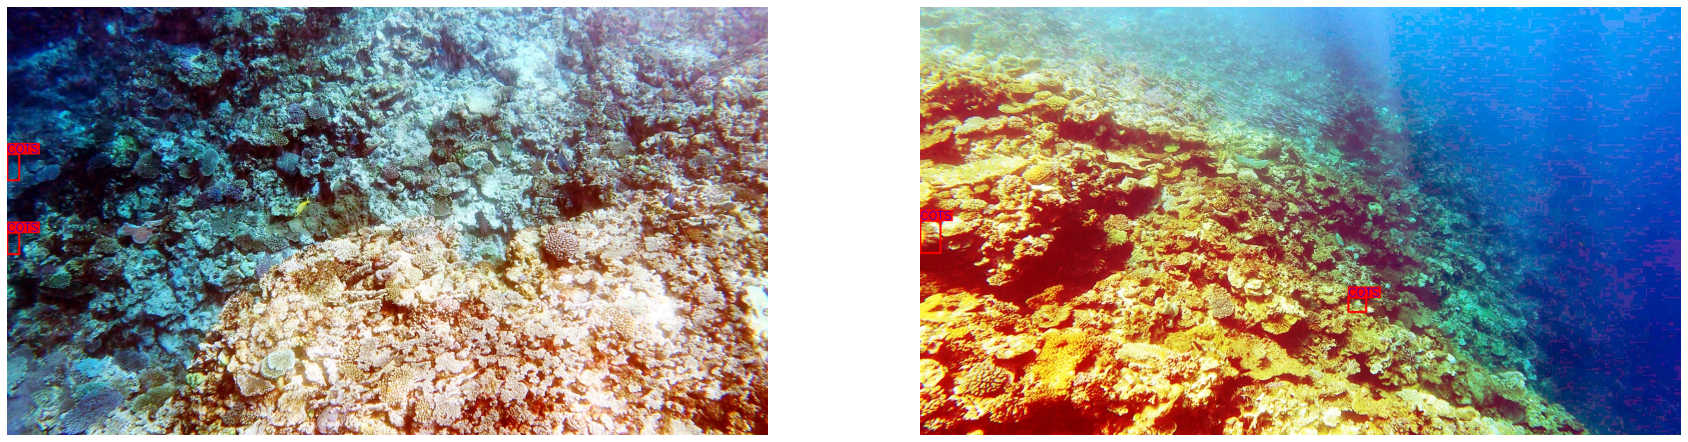

In [58]:
df_v = no_bbox_df_unannotated[(no_bbox_df_unannotated.NumOfBBoxUnannotated==2)].sample(2) 

fig,ax = plt.subplots(1,2,figsize=(30,20))
i=0;
for index, row in df_v.iterrows():
    #print(row)
    img           = load_image(row.image_path_unannotated)
    image_height  = 720
    image_width   = 1280
    bboxes_coco   = np.array(row.annotations_unannotated)
    bboxes_yolo   = coco2yolo(image_height, image_width, bboxes_coco)
    print(bboxes_yolo)
    names         = ['COTS']*len(bboxes_coco)
    confidences   = row.confidences
    labels        = confidences#[0]*len(bboxes_coco)
    im=draw_bboxes(img = img,
                           bboxes = bboxes_yolo, 
                           classes = names,
                           class_ids = labels,
                           class_name = True, 
                           colors = colors, 
                           bbox_format = 'yolo',
                           line_thickness = 2)
    ax[i].imshow(im)
    ax[i].axis('OFF')
    i=i+1

In [61]:
df_v

video_id  sequence  video_frame  sequence_frame image_id  ...  \
18956         2     26651         4888            1216   2-4888  ...   
5358          0     53708         9535             650   0-9535  ...   

                                              image_path  \
18956  ./input/tensorflow-great-barrier-reef//train_i...   
5358   ./input/tensorflow-great-barrier-reef//train_i...   

                                  image_path_unannotated  \
18956  ./working/data_dir/COTS_UNANNOTATED//images_pr...   
5358   ./working/data_dir/COTS_UNANNOTATED//images_pr...   

                      annotations_unannotated  \
18956    [[0, 248, 20, 44], [0, 380, 21, 35]]   
5358   [[0, 360, 34, 54], [720, 489, 30, 23]]   

                                    confidences NumOfBBoxUnannotated  
18956  [0.4690972864627838, 0.4370063543319702]                    2  
5358   [0.7788622975349426, 0.5140843391418457]                    2  

[2 rows x 12 columns]

In [59]:
# We will take all bboxes above 70 percent
from shutil import copyfile,copy
count=0 
for i in tqdm(range(len(no_bbox_df_unannotated))):
    row= no_bbox_df_unannotated.iloc[i]
    confidences= row.confidences
    x=False
    for confidence in confidences:
        if confidence>0.7:
            x= True
    if x:
        count=count+1
        copyfile(f'{row.image_path_unannotated}', f'./working/data_dir/COTS/images/train/{row.image_id}.jpg')
        image_height  = 720
        image_width   = 1280
        bboxes_coco   = np.array(row.annotations_unannotated)
        bboxes_yolo   = coco2yolo(image_height, image_width, bboxes_coco)
        annotation= create_annot(bboxes_yolo, bbox_format = 'yolo')
        with open(f'./working/data_dir/COTS/labels/train/{row.image_id}.txt','w') as file:
            file.write(annotation)
        
        #WE have some value with 70 percent confidence thus copy
        
    
    #if row.fold!=selected:
    #    copyfile(f'{row.image_path_preprocessed}', f'./working/data_dir/COTS/images/train/{row.image_id}.jpg')
    #else:
    #    copyfile(f'{row.image_path_preprocessed}', f'./working/data_dir/COTS/images/valid/{row.image_id}.jpg')

  0%|          | 0/657 [00:00<?, ?it/s]

In [60]:
print(f'No of pseudo labelled images added= {count}')

No of pseudo labelled images added= 218
